In [1]:
import numpy as np
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
%matplotlib inline
import re
import os
homedir=os.getenv('HOME')

In [2]:
#load phot table, vf table
#convert phot fluxes from nanomaggies to mJy --> multiply by 3.631e-3
#if no flux entry, replace with NaN
#header format must follow the following setup:
# id redshift filter1 filter1_err filter2 filter2_err filter3 filter3_err ...
#I *think* I will generate two input files? One for DEC>+32, one for DEC<+32 (will have different grz filters)
#for pcigale.ini (after pcigale genconf), may either have to MANUALLY edit file *or* try some automatic
# approach based on user-set parameters

#regarding the output files...
    #create empty table, same length as vf
    #add all VFIDs as first column
    #for every ID in output file, find correct row element and insert the desired parameters
    #CONVERT SFR, Mstar to log10!

In [3]:
#load tables
vf = Table.read(homedir+'/Desktop/v2-20220820/vf_v2_environment.fits')
phot = Table.read(homedir+'/Desktop/v2-20220820/vf_v2_legacy_ephot.fits')

In [4]:
#convert cosmic velocities to redshifts...v=cz for low-z objects
z = vf['Vcosmic']/3e5

In [5]:
#create flag to remove galaxies with negative z
z_flag = (z>0)

#also prepare phot flag, for later
phot_flag = (phot['photFlag'])

#combine flags
good_flag = z_flag & phot_flag

In [6]:
#trim tables
vf = vf[good_flag]
phot = phot[good_flag]
z = z[good_flag]

In [99]:
#isolate needed phot fluxes; convert from nanomaggies to mJy
#order: W1, W2, W3, W4, NUV, FUV, G, R

fluxes = [phot['FLUX_AP06_W1']*3.631e-3, phot['FLUX_AP06_W2']*3.631e-3, phot['FLUX_AP06_W3']*3.631e-3,
         phot['FLUX_AP06_W4']*3.631e-3, phot['FLUX_AP06_NUV']*3.631e-3, phot['FLUX_AP06_FUV']*3.631e-3,
         phot['FLUX_AP06_G']*3.631e-3, phot['FLUX_AP06_R']*3.631e-3]

flux_ivars = [phot['FLUX_IVAR_AP06_W1'], phot['FLUX_IVAR_AP06_W2'],
             phot['FLUX_IVAR_AP06_W3'], phot['FLUX_IVAR_AP06_W4'],
             phot['FLUX_IVAR_AP06_NUV'], phot['FLUX_IVAR_AP06_FUV'],
             phot['FLUX_IVAR_AP06_G'], phot['FLUX_IVAR_AP06_R']]

In [100]:
flux_errs = [np.zeros(len(phot)),np.zeros(len(phot)),np.zeros(len(phot)),np.zeros(len(phot)),
             np.zeros(len(phot)),np.zeros(len(phot)),np.zeros(len(phot)),np.zeros(len(phot))]

#for every list of fluxes...
for index in range(len(flux_ivars)):
    #for every element in that list of fluxes...
    for n in range(len(flux_errs[index])):
        #if zero or negative, replace with NaN
        #can do for both fluxes AND flux errors!
        if (flux_ivars[index][n]==0.) | (flux_ivars[index][n]<0.) | (fluxes[index][n]<0.) | (fluxes[index][n]==0.):
            flux_errs[index][n] = 'NaN'  
            fluxes[index][n] = 'NaN'
        #if not zero, calculate error as normal
        else:
            flux_errs[index][n] = np.sqrt(1/flux_ivars[index][n])*3.631e-3

In [101]:
#create table to organize results

faux_table = Table([phot['VFID'],np.round(z,4),fluxes[0],flux_errs[0],fluxes[1],flux_errs[1],
                   fluxes[2],flux_errs[2],fluxes[3],flux_errs[3],fluxes[4],flux_errs[4],
                   fluxes[5],flux_errs[5],fluxes[6],flux_errs[6],fluxes[7],flux_errs[7]],
                   names=['VFID','redshift','WISE1','WISE1_err','WISE2','WISE2_err','WISE3','WISE3_err',
                          'WISE4','WISE4_err','NUV','NUV_err','FUV','FUV_err','g','g_err','r','r_err'])

#I will need these flags as well. humph.
north_flag = phot['DEC_MOMENT']>32
south_flag = phot['DEC_MOMENT']<32

In [102]:
#write files...

with open(homedir+'/Desktop/cigale_vf_north/vf_data_north.txt', 'w') as file:
    #create file header
    s = '# id redshift FUV FUV_err NUV NUV_err g g_err r r_err WISE1 WISE1_err WISE2 WISE2_err WISE3 WISE3_err WISE4 WISE4_err'+' \n'
    file.write(s)
    
    #for every "good" galaxy in phot, add a row to the text file with relevant information
    for n in faux_table[north_flag]:
        
        s_gal = f"{n[0]} {n[1]} %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f"%(n[2],n[3],n[4],n[5],n[6],n[7],n[8],n[9],n[10],n[11],n[12],n[13],n[14],n[15],n[16],n[17]) + '\n'
        file.write(s_gal)
    
    file.close()    

with open(homedir+'/Desktop/cigale_vf_south/vf_data_south.txt', 'w') as file:
    #create file header
    s = '# id redshift FUV FUV_err NUV NUV_err g g_err r r_err WISE1 WISE1_err WISE2 WISE2_err WISE3 WISE3_err WISE4 WISE4_err'+' \n'
    file.write(s)
    
    #for every "good" galaxy in phot, add a row to the text file with relevant information
    for n in faux_table[south_flag]:
        
        s_gal = f"{n[0]} {n[1]} %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f"%(n[2],n[3],n[4],n[5],n[6],n[7],n[8],n[9],n[10],n[11],n[12],n[13],n[14],n[15],n[16],n[17]) + '\n'
        file.write(s_gal)
    
    file.close()    

In [43]:
#and that is that.

---

In [44]:
#I now need to create the pcigale.ini text file...
#the format is as follows:

#data_file = ___
#parameters_file = ___
#sed_modules = ___
#analysis_method = pdf_analysis
#cores = ___

#for now, we will use:

#data_file = vf_data_{north/south}.fits
#parameters_file = 
#sed_modules = sfh2exp, bc03, nebular, dustatt_modified_CF00, dl2014, redshifting
#analysis_method = pdf_analysis
#cores = 1

In [45]:
#write files...

with open(homedir+'/Desktop/cigale_vf_north/pcigale.ini', 'w') as file:
    file.write('data_file = vf_data_north.txt \n')
    file.write('parameters_file = \n')
    file.write('sed_modules = sfh2exp, bc03, nebular, dustatt_modified_CF00, dl2014, redshifting \n')
    file.write('analysis_method = pdf_analysis \n')
    file.write('cores = 1 \n')
    file.close()    

with open(homedir+'/Desktop/cigale_vf_south/pcigale.ini', 'w') as file:
    file.write('data_file = vf_data_south.txt \n')
    file.write('parameters_file = \n')
    file.write('sed_modules = sfh2exp, bc03, nebular, dustatt_modified_CF00, dl2014, redshifting \n')
    file.write('analysis_method = pdf_analysis \n')
    file.write('cores = 1 \n')
    file.close()    

---

In [48]:
#now that I have the main architecture, I will demonstrate the functionality of the .py files
#all column names are currently tailored to the VFS photometry catalog. subject to change.

In [341]:
%run VFS_generate_input_files_noz.py

Created /Users/k215c316/Desktop/cigale_vf_north
Created /Users/k215c316/Desktop/cigale_vf_south


<Figure size 640x480 with 0 Axes>

---

### Evaluating Results

In [342]:
#south=Table.read(homedir+'/Desktop/cigale_results/results_sfh2exp_south.fits')
#north=Table.read(homedir+'/Desktop/cigale_results/results_sfh2exp_north.fits')
south=Table.read(homedir+'/Desktop/cigale_vf_south/out/results.fits')
north=Table.read(homedir+'/Desktop/cigale_vf_north/out/results.fits')

In [343]:
fulltab = vstack([north,south])

In [344]:
magphys=Table.read(homedir+'/Desktop/galfit_files/vf-altphot.fits')

In [345]:
comtab=[]
for i in range(len(magphys)):
    if magphys['VFID'][i] in fulltab['id']:
        comtab.append(True)
    else:
        comtab.append(False)
magphys = magphys[comtab]

In [346]:
#various photometry flags from John's catalog

sat_flag = (~magphys['unsaturated_flag'])
medium_flag = (~magphys['nomedstar_flag'])
wisestar_flag = (~magphys['nowisestar_flag'])
bad_phot_flag = (~magphys['good_phot_flag'])

phot_flags = sat_flag | medium_flag | wisestar_flag | bad_phot_flag

#good_phot_flag --> Vcosmic>0 AND AP06 flux > 0 in every band
#unsaturated_flag --> grz bands are NOT saturated
#nomedstar_flag --> no medium star
#nowisestar_flag --> no WISE star

In [347]:
magphys_cut = magphys[phot_flags]
cigale_cut = fulltab[phot_flags]

In [348]:
magphys_mass = magphys_cut['MAGPHYS_logMstar_med']
magphys_sfr = magphys_cut['MAGPHYS_logSFR_med']
cigale_mass = np.log10(cigale_cut['bayes.stellar.m_star'])
cigale_sfr = np.log10(cigale_cut['bayes.sfh.sfr'])

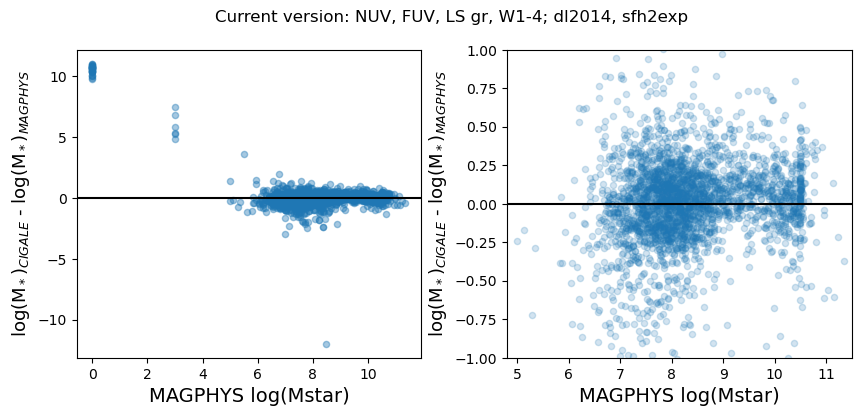

In [349]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(wspace=0.25)
ax1.scatter(magphys_mass, cigale_mass - magphys_mass,s=20,alpha=0.4)
ax1.axhline(0,color='black')
ax2.scatter(magphys_mass,cigale_mass - magphys_mass,s=20,alpha=0.2)
ax2.axhline(0,color='black')
ax2.set_xlim(4.8,11.5)
ax2.set_ylim(-1,1)
#ax2.set_ylim(-5,5)

ax1.set_xlabel('MAGPHYS log(Mstar)',fontsize=14)
ax1.set_ylabel(r'log(M$_*$)$_{CIGALE}$ - log(M$_*$)$_{MAGPHYS}$',fontsize=13)
ax2.set_xlabel('MAGPHYS log(Mstar)',fontsize=14)
ax2.set_ylabel(r'log(M$_*$)$_{CIGALE}$ - log(M$_*$)$_{MAGPHYS}$',fontsize=13)

plt.suptitle("Current version: NUV, FUV, LS gr, W1-4; dl2014, sfh2exp", fontsize=12)
plt.show()

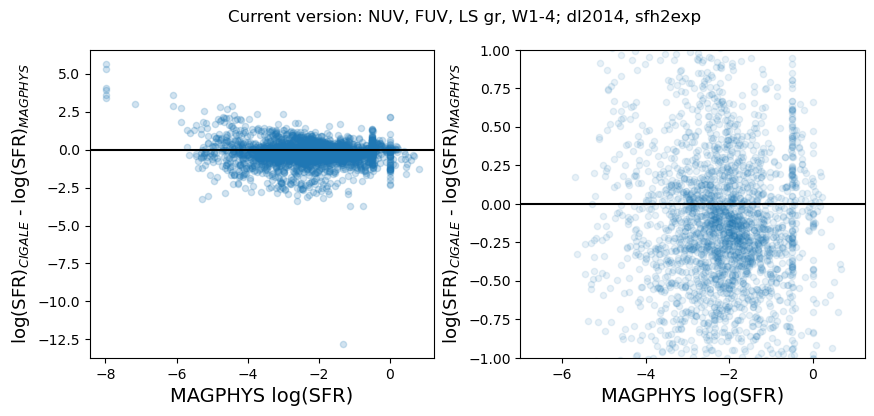

-0.19619368198857456


In [350]:
#flag = (magphys['MAGPHYS_logSFR_med'][comtab] > -7) & (magphys['MAGPHYS_logSFR_med'][comtab] < -0.6)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(wspace=0.25)
ax1.scatter(magphys_sfr, cigale_sfr - magphys_sfr,s=20,alpha=0.2)
ax1.axhline(0,color='black')
ax2.scatter(magphys_sfr, cigale_sfr - magphys_sfr,s=20,alpha=0.1)
ax2.axhline(0,color='black')
ax2.set_xlim(-7,)
ax2.set_ylim(-1,1)

ax1.set_xlabel('MAGPHYS log(SFR)',fontsize=14)
ax1.set_ylabel(r'log(SFR)$_{CIGALE}$ - log(SFR)$_{MAGPHYS}$',fontsize=13)
ax2.set_xlabel('MAGPHYS log(SFR)',fontsize=14)
ax2.set_ylabel(r'log(SFR)$_{CIGALE}$ - log(SFR)$_{MAGPHYS}$',fontsize=13)

plt.suptitle("Current version: NUV, FUV, LS gr, W1-4; dl2014, sfh2exp", fontsize=12)
plt.show()

print(np.median(cigale_sfr-magphys_sfr))

In [414]:
np.log10(fulltab[fulltab['id']=='VFID0005']['bayes.stellar.m_star'])

9.820775840925014


In [312]:
#fulltab.write(homedir+'/Desktop/CIGALE_comb_output.fits')

### Notes and Troubleshooting Attempts

In [13]:
#changed grz headers from 'energy' to 'photon.' numbers match original txtfiles. gives same results as when
#I keep 'energy.'

#---confirmed that generated table has correct flux information...converted from nanomaggies to mJy (*3.631e-3)
#also tried changing energy values of grz filters from Jy (I presume) to mJy...no change

#appears that best-fit models really only pass through W3 and W4 measurements...relatively high chi-squared values

#changing to SDSS g_prime, r_prime only negligibly affects results. but that is also curious, since I previously
#found a different value for VFID0005 logMstar with those SDSS filters! ~8.65. what changed? *the parameters.*
    #reverting to initial parameters...sfhdelayed and dale2014. THESE recover that logMstar = 9.36 value for VFID0005.
#however...instructed to instead use sfh2exp and dl2014. with sfhdelayed and dale2014, result is ~9.01.
#now, using the legacy survey filters with sfhdelayed and dale2014, ... again, MINIMAL difference. curious indeed.

#next test: using galex.NUV, galex.FUV --> different from NUV, FUV?
    #...negligible change. dlogMstar ~0.0001

#next next test: implementing z-band?
    #somewhat negligible change. dlogMstar ~0.01

#and now... I default to sfhdelayed, dl2014, and generate with sed plots.
#I keep the z-band values.

#CIGALE may just be the reason I develop a hernia.

In [78]:
#two remaining ideas...

#(1) compare MAGPHYS NUV, FUV textfiles with CIGALE's files
    #I can't seem to do so. MAGPHYS' filters are all embedded in the same binary file, which I cannot read.

#(2) try different combinations of parameters -- do any fit the smaller wavelength fluxes more robustly?
    
    #well...I will not bother much with this point. HOWEVER, it did engender a new thought
        
        #only 3 models generated per galaxy, then the best-fit is taken from these models. that is not a lot of models.
        #if I add more potential values to some of the parameter arguments, then the number of models rises
        #(can check by typing "pcigale check" while in the same directory as pcigale.ini)
        
        #do I need to tweak the parameters somehow to better reflect the nature of the galaxy population?
        #or maybe add multiple options (comma-separated in the relevant spots of the file)?
        
        #this is where I am currently stuck --> I have not the knowledge, really, to pursue this further.
        
        #naively, though, I assume that the generation of more physically-motivated models (rather than
        #just using default parameter values) may be a benefit here.
        
        #and...do I need to include any AGN modules? 
        
#what am I doing? :-/

#OKAY! I ADDED A FEW DIFFERENT VALUES FOR tau main (500., 2000. (default)) and 
#age_main = (100, 300, 500, 3e3, 5e3 (default?)). stellar mass results are slightly higher, so 1-to-1
#is marginally better? still unsure about correct parameters to use, but this is promising!
#(the use of "better" is predicated on the (likely) untenable assumption that MAGPHYS stellar masses are correct)

#another note...in pcigale.ini, under [analysis_params], can specify desired BAYES variables (similar to median
#model parameters in MAGPHYS table?). can do sfh.sfr, stellar.m_star

#comparing VFID0005 SED models, ... not terribly impressed.

#NOTE: when I want to permanently implement module parameter changes, I must edit the run_cigale.py file 
#(similar to how I edited the save_best_sed = True line)
#when I'm just testing, I can directly edit the pcigale.ini files, then type "pcigale run" in that directory.
#for .pdf files, in that same directory, then type pcigale-plots sed

In [228]:
#AUGUST 1, 2024 notizen.
#met with Greg; will be running CIGALE *again* with additional comma-separated parameters, which
#are not only more numerous than my juvenile initial guess, but also better motivated.
#also am now applying MW-transmission (MW == Milky Way) correction. 
    #given in vf_v2_extinction.fits (magnitudes) --> then convert to linear scale factor
    #using (10.**(ext_value[f'A({i})_SFD']/2.5)), where i is the filter name.

#ALSO --> VALUES FOR AGE_BURST *CANNOT* BE LARGER THAN THE SMALLEST VALUE FOR AGE_MAIN

#AUGUST 5, 2024 notizen
#adding additional parameters options for A_v was effective! The fits now look quite robust!
#However, the uncertainties attached to the Bayes output parameters remain a bit...large. 

---

### For Tom's Herschel Sample

In [404]:
#create pcigale.ini files
with open(homedir+'/Desktop/cigale_vf_north_tom/pcigale.ini', 'w') as file:
    file.write('data_file = vf_data_north.txt \n')
    file.write('parameters_file = \n')
    file.write('sed_modules = sfh2exp, bc03, nebular, dustatt_modified_CF00, dl2014, skirtor2016, redshifting \n')
    file.write('analysis_method = pdf_analysis \n')
    file.write('cores = 1 \n')
    file.close()    
with open(homedir+'/Desktop/cigale_vf_south_tom/pcigale.ini', 'w') as file:
    file.write('data_file = vf_data_south.txt \n')
    file.write('parameters_file = \n')
    file.write('sed_modules = sfh2exp, bc03, nebular, dustatt_modified_CF00, dl2014, skirtor2016, redshifting \n')
    file.write('analysis_method = pdf_analysis \n')
    file.write('cores = 1 \n')
    file.close()    

#create pcigale.ini.spec files

with open(homedir+'/Desktop/cigale_vf_north_tom/pcigale.ini.spec', 'w') as file:
    file.write('data_file = string() \n')
    file.write('parameters_file = string() \n')
    file.write('sed_modules = cigale_string_list() \n')
    file.write('analysis_method = string() \n')
    file.write('cores = integer(min=1)')
    file.close()
with open(homedir+'/Desktop/cigale_vf_south_tom/pcigale.ini.spec', 'w') as file:    
    file.write('data_file = string() \n')
    file.write('parameters_file = string() \n')
    file.write('sed_modules = cigale_string_list() \n')
    file.write('analysis_method = string() \n')
    file.write('cores = integer(min=1) \n')
    file.close() 